In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pqm import pqm_chi2, pqm_pvalue
from scipy.stats import norm, chi2, uniform, kstest

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
plt.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
plt.rc("text", usetex=True)

Create a distribution, and sample from it twice

In [2]:
class TimeSeriesModel:
    def __init__(self, a = 0., sigma=1., nt=100):
        self.t = np.linspace(0, 10, nt)
        self.a = a
        self.sigma = sigma
        
    def generate_samples(self, num_samples):
        # Generate samples from each component
        y = self.a * np.cos(self.t) + self.sigma * np.random.randn(num_samples, len(self.t))
        return y


In [3]:
num_repeats = 20
gmm_null = TimeSeriesModel(a = 0)

amps = np.logspace(-2, 0, 20)
chisqs_mean = np.zeros_like(amps)
chisqs_std = np.zeros_like(amps)

for i, a in enumerate(amps):
    gmm = TimeSeriesModel(a = a)
    null_samples = gmm_null.generate_samples(num_samples=5000)
    y_samples = gmm.generate_samples(num_samples=5000)
    zs = []
    for _ in range(num_repeats):
        z = pqm_chi2(y_samples, null_samples)
        zs.append(z)
        
    chisqs_mean[i] = np.median(zs)
    chisqs_std[i] = np.std(zs)
    print(a, chisqs_mean[i], chisqs_std[i])

0.01 101.8060834988602 15.554635843895161
0.012742749857031334 96.62637052804726 9.04051050274939
0.016237767391887217 103.28695687492157 11.510920281637269
0.0206913808111479 94.16428784194059 11.768393286322361
0.026366508987303583 112.29198621843746 14.691044275525506
0.03359818286283781 100.87985806702318 13.884186295195038
0.04281332398719394 101.49725971020106 9.230807135126653
0.0545559478116852 108.52242969836146 17.625619037048622
0.06951927961775606 145.3931397287824 18.36138467817544
0.08858667904100823 146.13284001555863 17.3142561268065
0.11288378916846889 183.96552333522732 26.665437564894663
0.14384498882876628 248.31221263317548 41.17426910059236
0.18329807108324356 327.65017950264973 58.460721956784184
0.23357214690901212 399.49488693891226 71.39231046792266
0.29763514416313175 610.3408232462023 114.15715787490471
0.37926901907322497 1049.7187715149266 181.15009814135186
0.4832930238571752 1321.019438955153 220.96517845787312
0.615848211066026 1968.1711814925984 317.09

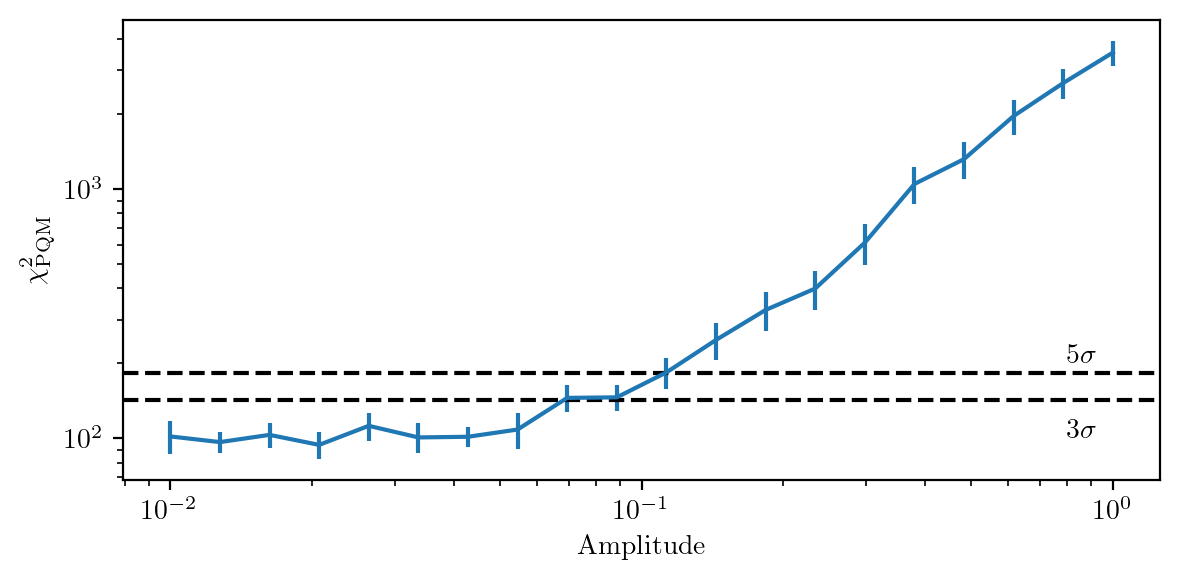

In [4]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.errorbar(amps, chisqs_mean, yerr=chisqs_std)
ax.axhline(chi2.ppf(0.997300203936740, 99), ls='--', color='k')
ax.axhline(chi2.ppf(0.999999426696856, 99), ls='--', color='k')
ax.text(0.8, 100, r'$3 \sigma$')
ax.text(0.8, 200, r'$5 \sigma$')
ax.set_xlabel('Amplitude')
ax.set_ylabel('$\chi^2_{\mathrm{ PQM}}$')
ax.set_yscale('log')
ax.set_xscale('log')
plt.tight_layout()
plt.show()

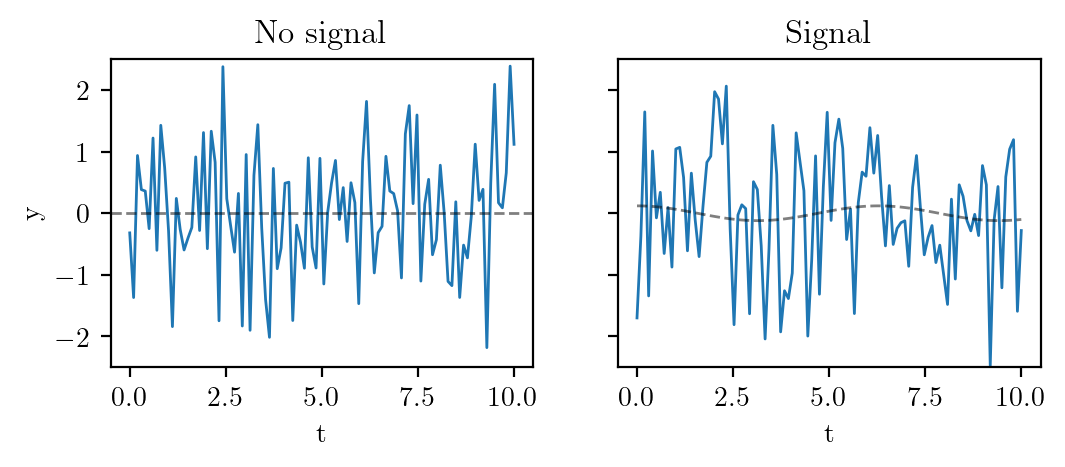

In [5]:
gmm = TimeSeriesModel(a = 0.12)
gmm_null = TimeSeriesModel(a = 0)
x_samples = gmm.generate_samples(num_samples=2)
null_samples = gmm_null.generate_samples(num_samples=2)

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(6, 2), sharex=True, sharey=True)
axs[0].plot(gmm.t, null_samples[0], lw=1)
axs[0].axhline(0, color='k', lw=1, ls='--', alpha=0.5)
axs[0].set_ylim([-2.5, 2.5])
axs[0].set_xlabel('t')
axs[0].set_ylabel('y')
axs[0].set_title('No signal')

axs[1].plot(gmm.t, x_samples[0], lw=1)
axs[1].plot(gmm.t, gmm.a * np.cos(gmm.t), color='k', lw=1, ls='--', alpha=0.5)
axs[1].set_ylim([-2.5, 2.5])
axs[1].set_title('Signal')
axs[1].set_xlabel('t')

plt.show()

# Using p-value

In [8]:
num_repeats = 20
gmm_null = TimeSeriesModel(a = 0)

amps = np.logspace(-2, 0, 20)
p_val_mean = np.zeros_like(amps)
p_val_std = np.zeros_like(amps)

for i, a in enumerate(amps):
    gmm = TimeSeriesModel(a = a)
    null_samples = gmm_null.generate_samples(num_samples=5000)
    y_samples = gmm.generate_samples(num_samples=5000)
    p_val = []
    for _ in range(num_repeats):
        pval = pqm_pvalue(y_samples, null_samples)
        p_val.append(pval)
    p_val_mean[i] = np.median(p_val)
    p_val_std[i] = np.std(p_val)

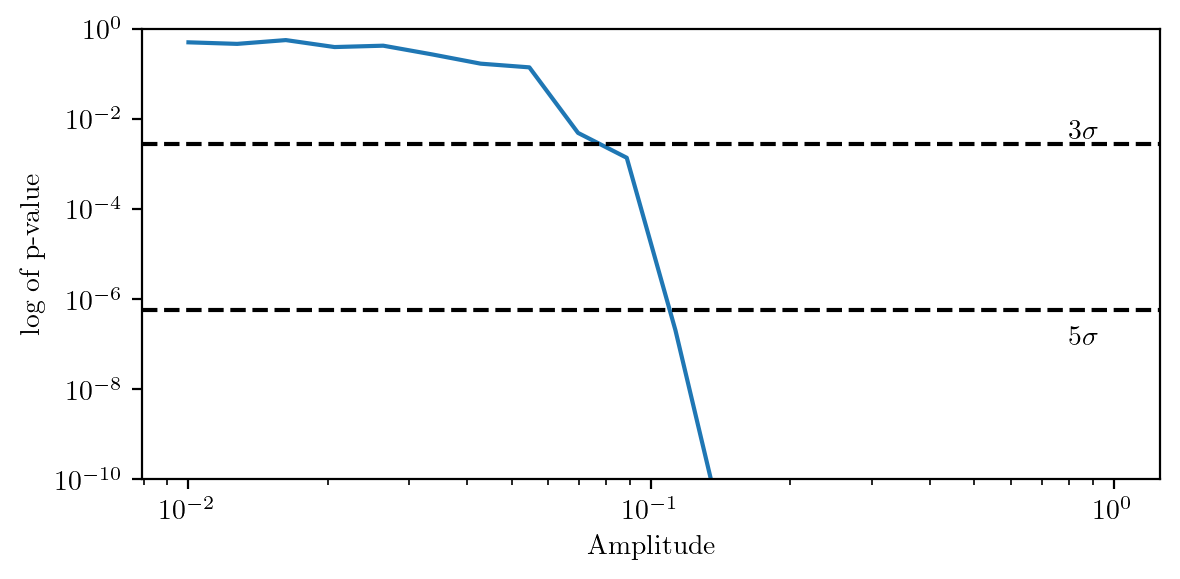

In [7]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(amps, p_val_mean)
ax.axhline(1 - 0.997300203936740, ls='--', color='k')  # 3 sigma equivalent p-value
ax.axhline(1 - 0.999999426696856, ls='--', color='k')  # 5 sigma equivalent p-value
ax.text(0.8, 0.01, r'$3 \sigma$', verticalalignment='top')
ax.text(0.8, 0.0000001, r'$5 \sigma$')
ax.set_xlabel('Amplitude')
ax.set_ylabel('log of p-value')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-10, 1)  # Set the y-axis limits
plt.tight_layout()
plt.show()
